<a href="https://colab.research.google.com/github/DGkurnia/cnkproject/blob/main/Submisi_Akhir_BMLP_Derfansyah_Guswiranata_Kurnia_clus_ii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perkenalan diri
## Nmaa: Derfansyah Guswiranata Kurnia
## email dicoding: weerakurnia@gmail.com
## Identitas dicoding : dgkurnia

# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

In [ ]:
#Pengunduhan perpustakaan untuk Dataset
import numpy as np
import pandas as pd
#Grafik
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Perpustakaan untuk Google drive demi impor data
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#impor dataset untuk Data
airbnbdf = pd.read_csv('/content/drive/MyDrive/csv-files/airbnb-revi.csv') # skip bad lines
#Penyalinan data
airbnbc = airbnbdf.copy()

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [ ]:
#persiapan perpustakaan
from sklearn.preprocessing import RobustScaler
#inspeksi nilai siluet
from sklearn.metrics import silhouette_score

In [ ]:
#inisiasi 'pelabelan banyak' dan 'identifikasi jarak'
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.spatial import distance

In [ ]:
#perpustakaan untuk interpolasi
from scipy.interpolate import interp1d

In [ ]:
#optsional 'kneed'
!pip install kneed
from kneed import KneeLocator

In [ ]:
#Perpustakaan untuk fungsi K-means
from sklearn.cluster import KMeans

In [ ]:
#inisiasi category_encoders
!pip install category_encoders
import category_encoders as ce

In [ ]:
#Silhouette visualizer
!pip install yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [ ]:
#Inspeksi data
airbnbc.columns

In [ ]:
#cek data hilang
airbnbc.isna().sum()

In [ ]:
#cek data kosong
airbnbc.isnull().sum()

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [ ]:
#cek jenis data
airbnbc.dtypes

,0
id,int64
name,object
host_id,int64
host_name,object
neighbourhood_group,object
neighbourhood,object
latitude,float64
longitude,float64
room_type,object
price,int64


In [ ]:
#Fungsi Inspeksi data
def countsplot(category):
  # Create count plot with dynamic title
  plt.figure(figsize = (10, 9))
  sns.countplot(data = airbnbc, x = category)
  plt.ylabel("Count")
  plt.title(f"{category} Distribution")
  plt.show()

  # Perhitungan nilai dan persentase
  category_counts = airbnbc[category].value_counts() #Nilai perhitungan
  category_percentages = airbnbc[category].value_counts(normalize = True) #Persentase

  # Penggabungan nilai dan persentase menjadi satu Data frama
  stats_df = pd.DataFrame({"Count": category_counts, "Proportion": category_percentages})
  stats_df["Count"] = stats_df["Count"].apply("{:,}".format)
  stats_df["Proportion"] = stats_df["Proportion"].apply("{:.1%}".format)

  return stats_df

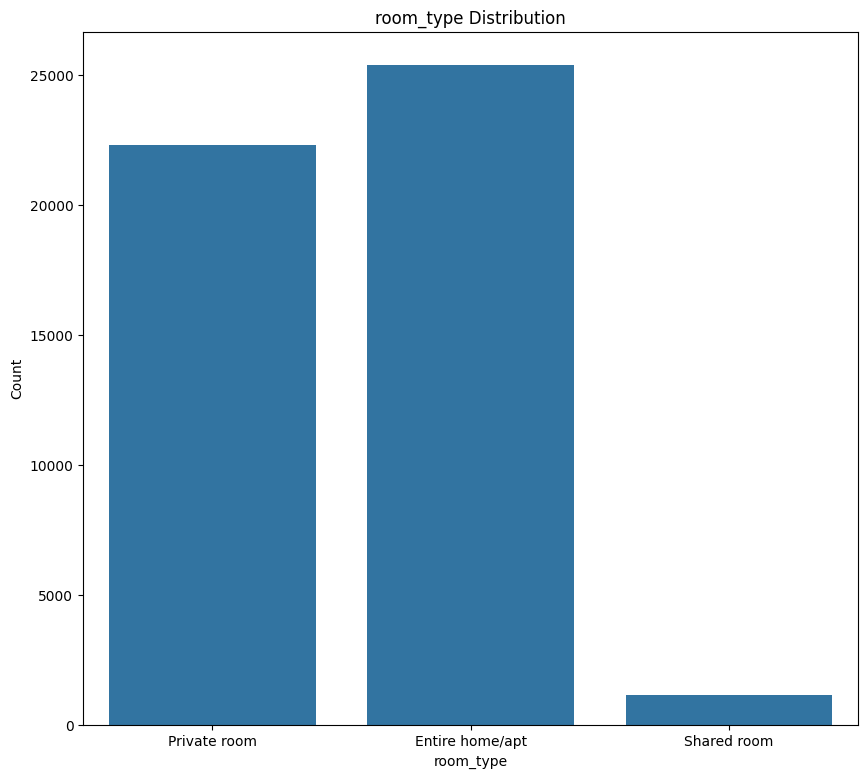

,Count,Proportion
room_type,,
Entire home/apt,"25,409",52.0%
Private room,"22,326",45.7%
Shared room,"1,160",2.4%


In [ ]:
#grafik implementasi data
countsplot('room_type')

**Grafik ini menjadi basis pemakaian kluster sebelum digabung**

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang perlu dilakukan, namun **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

In [ ]:
#tahap awal: pergantian dua jenis kolom melalui koversi identitas
airbnbc[['id','host_id']] = airbnbc[['id','host_id']].astype('str').copy()
airbnbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  object 
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  object 
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
#tahap dua : pengurusan kolom tanggal
airbnbc['last_review'] = pd.to_datetime(airbnbc['last_review']).copy()
airbnbc['last_review'] = airbnbc['last_review'].fillna(pd.Timestamp(0)).copy() #tidak akan dipakai
airbnbc['price'].interpolate(method='nearest') #interpolasi 1 untuk biaya
airbnbc['price'].interpolate(method='linear') #interpolasi 1 untuk biaya
airbnbc['reviews_per_month'].interpolate(method='nearest')
airbnbc['reviews_per_month'].interpolate(method='linear')
airbnbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  object        
 1   name                            48879 non-null  object        
 2   host_id                         48895 non-null  object        
 3   host_name                       48874 non-null  object        
 4   neighbourhood_group             48895 non-null  object        
 5   neighbourhood                   48895 non-null  object        
 6   latitude                        48895 non-null  float64       
 7   longitude                       48895 non-null  float64       
 8   room_type                       48895 non-null  object        
 9   price                           48895 non-null  int64         
 10  minimum_nights                  48895 non-null  int64         
 11  nu

In [ ]:
#pengisian kolom kosong (Pengisian nilai untuk kolom tidak ada di data numerik)
airbnbc[['minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count', 'availability_365']] = airbnbc[['minimum_nights', 'number_of_reviews','reviews_per_month','calculated_host_listings_count', 'availability_365']].fillna(0).copy()

# Pengubahan nilai kosong
airbnbc.replace([np.inf, -np.inf], 0, inplace=True)

# Konversi ke kolom angka
airbnbc[['minimum_nights', 'number_of_reviews','reviews_per_month','calculated_host_listings_count', 'availability_365']] = airbnbc[['minimum_nights', 'number_of_reviews','reviews_per_month','calculated_host_listings_count', 'availability_365']].astype('int64').copy()
airbnbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  object        
 1   name                            48879 non-null  object        
 2   host_id                         48895 non-null  object        
 3   host_name                       48874 non-null  object        
 4   neighbourhood_group             48895 non-null  object        
 5   neighbourhood                   48895 non-null  object        
 6   latitude                        48895 non-null  float64       
 7   longitude                       48895 non-null  float64       
 8   room_type                       48895 non-null  object        
 9   price                           48895 non-null  int64         
 10  minimum_nights                  48895 non-null  int64         
 11  nu

In [ ]:
#Pengisian data non numerik
#Pengisian kolom kosong di jenis data kata
airbnbc['name'].fillna('No Name') #kolom nama kamar
airbnbc['host_name'].fillna('Unidentified') #kolom nama pemilik
airbnbc[['neighbourhood_group', 'neighbourhood']] = airbnbc[['neighbourhood_group', 'neighbourhood']].fillna('Unknown') #Lokais dan Kota
airbnbc['room_type'].fillna('Unspecified')
airbnbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  object        
 1   name                            48879 non-null  object        
 2   host_id                         48895 non-null  object        
 3   host_name                       48874 non-null  object        
 4   neighbourhood_group             48895 non-null  object        
 5   neighbourhood                   48895 non-null  object        
 6   latitude                        48895 non-null  float64       
 7   longitude                       48895 non-null  float64       
 8   room_type                       48895 non-null  object        
 9   price                           48895 non-null  int64         
 10  minimum_nights                  48895 non-null  int64         
 11  nu

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [ ]:
#Pembagian data bedasarkan kamar
funi, pri, sha,*_ = airbnbc['room_type'].unique().copy() #seleksi jenis kamar
#unit penuh
funidf = airbnbc[airbnbc['room_type'] == funi].copy()
funidf.reset_index(drop=True, inplace=True)
funidfcs = funidf[['room_type','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']].copy()
#kamar privat
pridf = airbnbc[airbnbc['room_type'] == pri].copy()
pridf.reset_index(drop=True, inplace=True)
pridfcs = pridf[['room_type','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']].copy()
#kamar berbagi
shadf = airbnbc[airbnbc['room_type'] == sha].copy()
shadf.reset_index(drop=True, inplace=True)
shadfcs = shadf[['room_type','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']].copy()

In [ ]:
#cek kelompok data
funidfcs.info() #info untuk kamar penuh
pridfcs.info() #info untuk kamar privat
shadfcs.info() #info untuk kamar berbagi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22326 entries, 0 to 22325
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   room_type                       22326 non-null  object
 1   price                           22326 non-null  int64 
 2   minimum_nights                  22326 non-null  int64 
 3   number_of_reviews               22326 non-null  int64 
 4   reviews_per_month               22326 non-null  int64 
 5   calculated_host_listings_count  22326 non-null  int64 
 6   availability_365                22326 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25409 entries, 0 to 25408
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   room_type                       25409 non-null  object
 1   price    

**Tujuan utama dari pemisahan adalah inspeksi untuk kluster nanti**

In [ ]:
#Penyatuan dataset menjadi satu
clsdf = pd.concat([funidfcs, pridfcs, shadfcs], axis=0).copy()
clsdf.reset_index(drop=True, inplace=True)
clsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   room_type                       48895 non-null  object
 1   price                           48895 non-null  int64 
 2   minimum_nights                  48895 non-null  int64 
 3   number_of_reviews               48895 non-null  int64 
 4   reviews_per_month               48895 non-null  int64 
 5   calculated_host_listings_count  48895 non-null  int64 
 6   availability_365                48895 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 2.6+ MB


### Persiapan untuk cluster

In [ ]:
#pengubahan data 'jenis kamar' menjadi kata-kata
clsdf['room_type'] = clsdf['room_type'].astype(str).copy()
#inisiasi tipe
clsdf['room_type'] = clsdf['room_type'].apply(lambda x: x.split(','))
#Inisiasi Multi label binarizer
mlb = MultiLabelBinarizer()
clsdflb = mlb.fit_transform(clsdf['room_type'])
#penggabungan hail ke bagian lain

In [ ]:
#pengubahan ke df
clsdfr = pd.DataFrame(clsdflb, columns=mlb.classes_)
clsdfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ['0']   48895 non-null  int64
dtypes: int64(1)
memory usage: 382.1 KB


In [ ]:
#Persiapan untuk 'Robust Scaler'
scaler = RobustScaler()

In [ ]:
#persiapan untuk ronust scaler
clsdfrbs = scaler.fit_transform(clsdf)
#konversi ke bentuk nilai
clsdfres = pd.DataFrame(clsdfrbs, columns=clsdf.columns)
clsdfres.head()

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,0.0,0.405660,-0.50,0.173913,0.0,5.0,1.409692
1,0.0,0.415094,0.00,-0.217391,0.0,0.0,1.409692
2,0.0,-0.433962,10.50,1.913043,0.0,0.0,-0.198238
3,0.0,-0.254717,-0.25,18.478261,3.0,0.0,0.770925
4,0.0,-0.254717,-0.25,4.913043,0.0,0.0,-0.198238


In [ ]:
#persiapan nilai
cladfv = cladfres.values


### Basis untuk kluster adalah
- inspeksi harga
- malam minimal
- total ulasan
- ulasan per bulan
### Aspek ini akan dibandingkan dengan kamar


In [ ]:
#Penggabungan kembali hasil
clsdfcom = pd.concat([clsdfr, clsdfrbs], axis=1).copy()
clsdfcom.drop('room_type', axis=1, inplace=True)
clsdfcom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   0                               48895 non-null  int64  
 1   price                           48895 non-null  float64
 2   minimum_nights                  48895 non-null  float64
 3   number_of_reviews               48895 non-null  float64
 4   reviews_per_month               48895 non-null  float64
 5   calculated_host_listings_count  48895 non-null  float64
 6   availability_365                48895 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 2.6 MB


data yang dipakai adalah 'clsdfcom' yang berasal dari gabungan data sebelumnya

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [ ]:
#fungsi
def inspeksi_kluster(clsdfcom, cluster_range=range(2, 11), random_states=[1000], optsil=0.70, silmin=0.55):
    fig, ax = plt.subplots(5, 2, figsize=(20, 31))

    # Iterasi setaiap 'fasa acak'
    for random_state in random_states:
        print(f"Dengan fasa acak: {random_state}")

        # Iterate through the specified range of clusters
        for n_clusters in cluster_range:
            kmeanModel = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
            kmeanModel.fit(clsdfcom.values)

            q, mod = divmod(n_clusters, 2)
            sil = SilhouetteVisualizer(kmeanModel, is_fitted=True, ax=ax[q-1][mod])
            sil.fit(clsdfcom.values)
            sil.finalize()

            print(f"Kluster: {n_clusters}, NIlai siluet: {np.round(sil.silhouette_score_,4)}")

Dengan fasa acak: 1000
Kluster: 2, NIlai siluet: 0.9647
Kluster: 3, NIlai siluet: 0.939
Kluster: 4, NIlai siluet: 0.916
Kluster: 5, NIlai siluet: 0.8581
Kluster: 6, NIlai siluet: 0.6458
Kluster: 7, NIlai siluet: 0.4733
Kluster: 8, NIlai siluet: 0.4858
Kluster: 9, NIlai siluet: 0.4746
Kluster: 10, NIlai siluet: 0.475


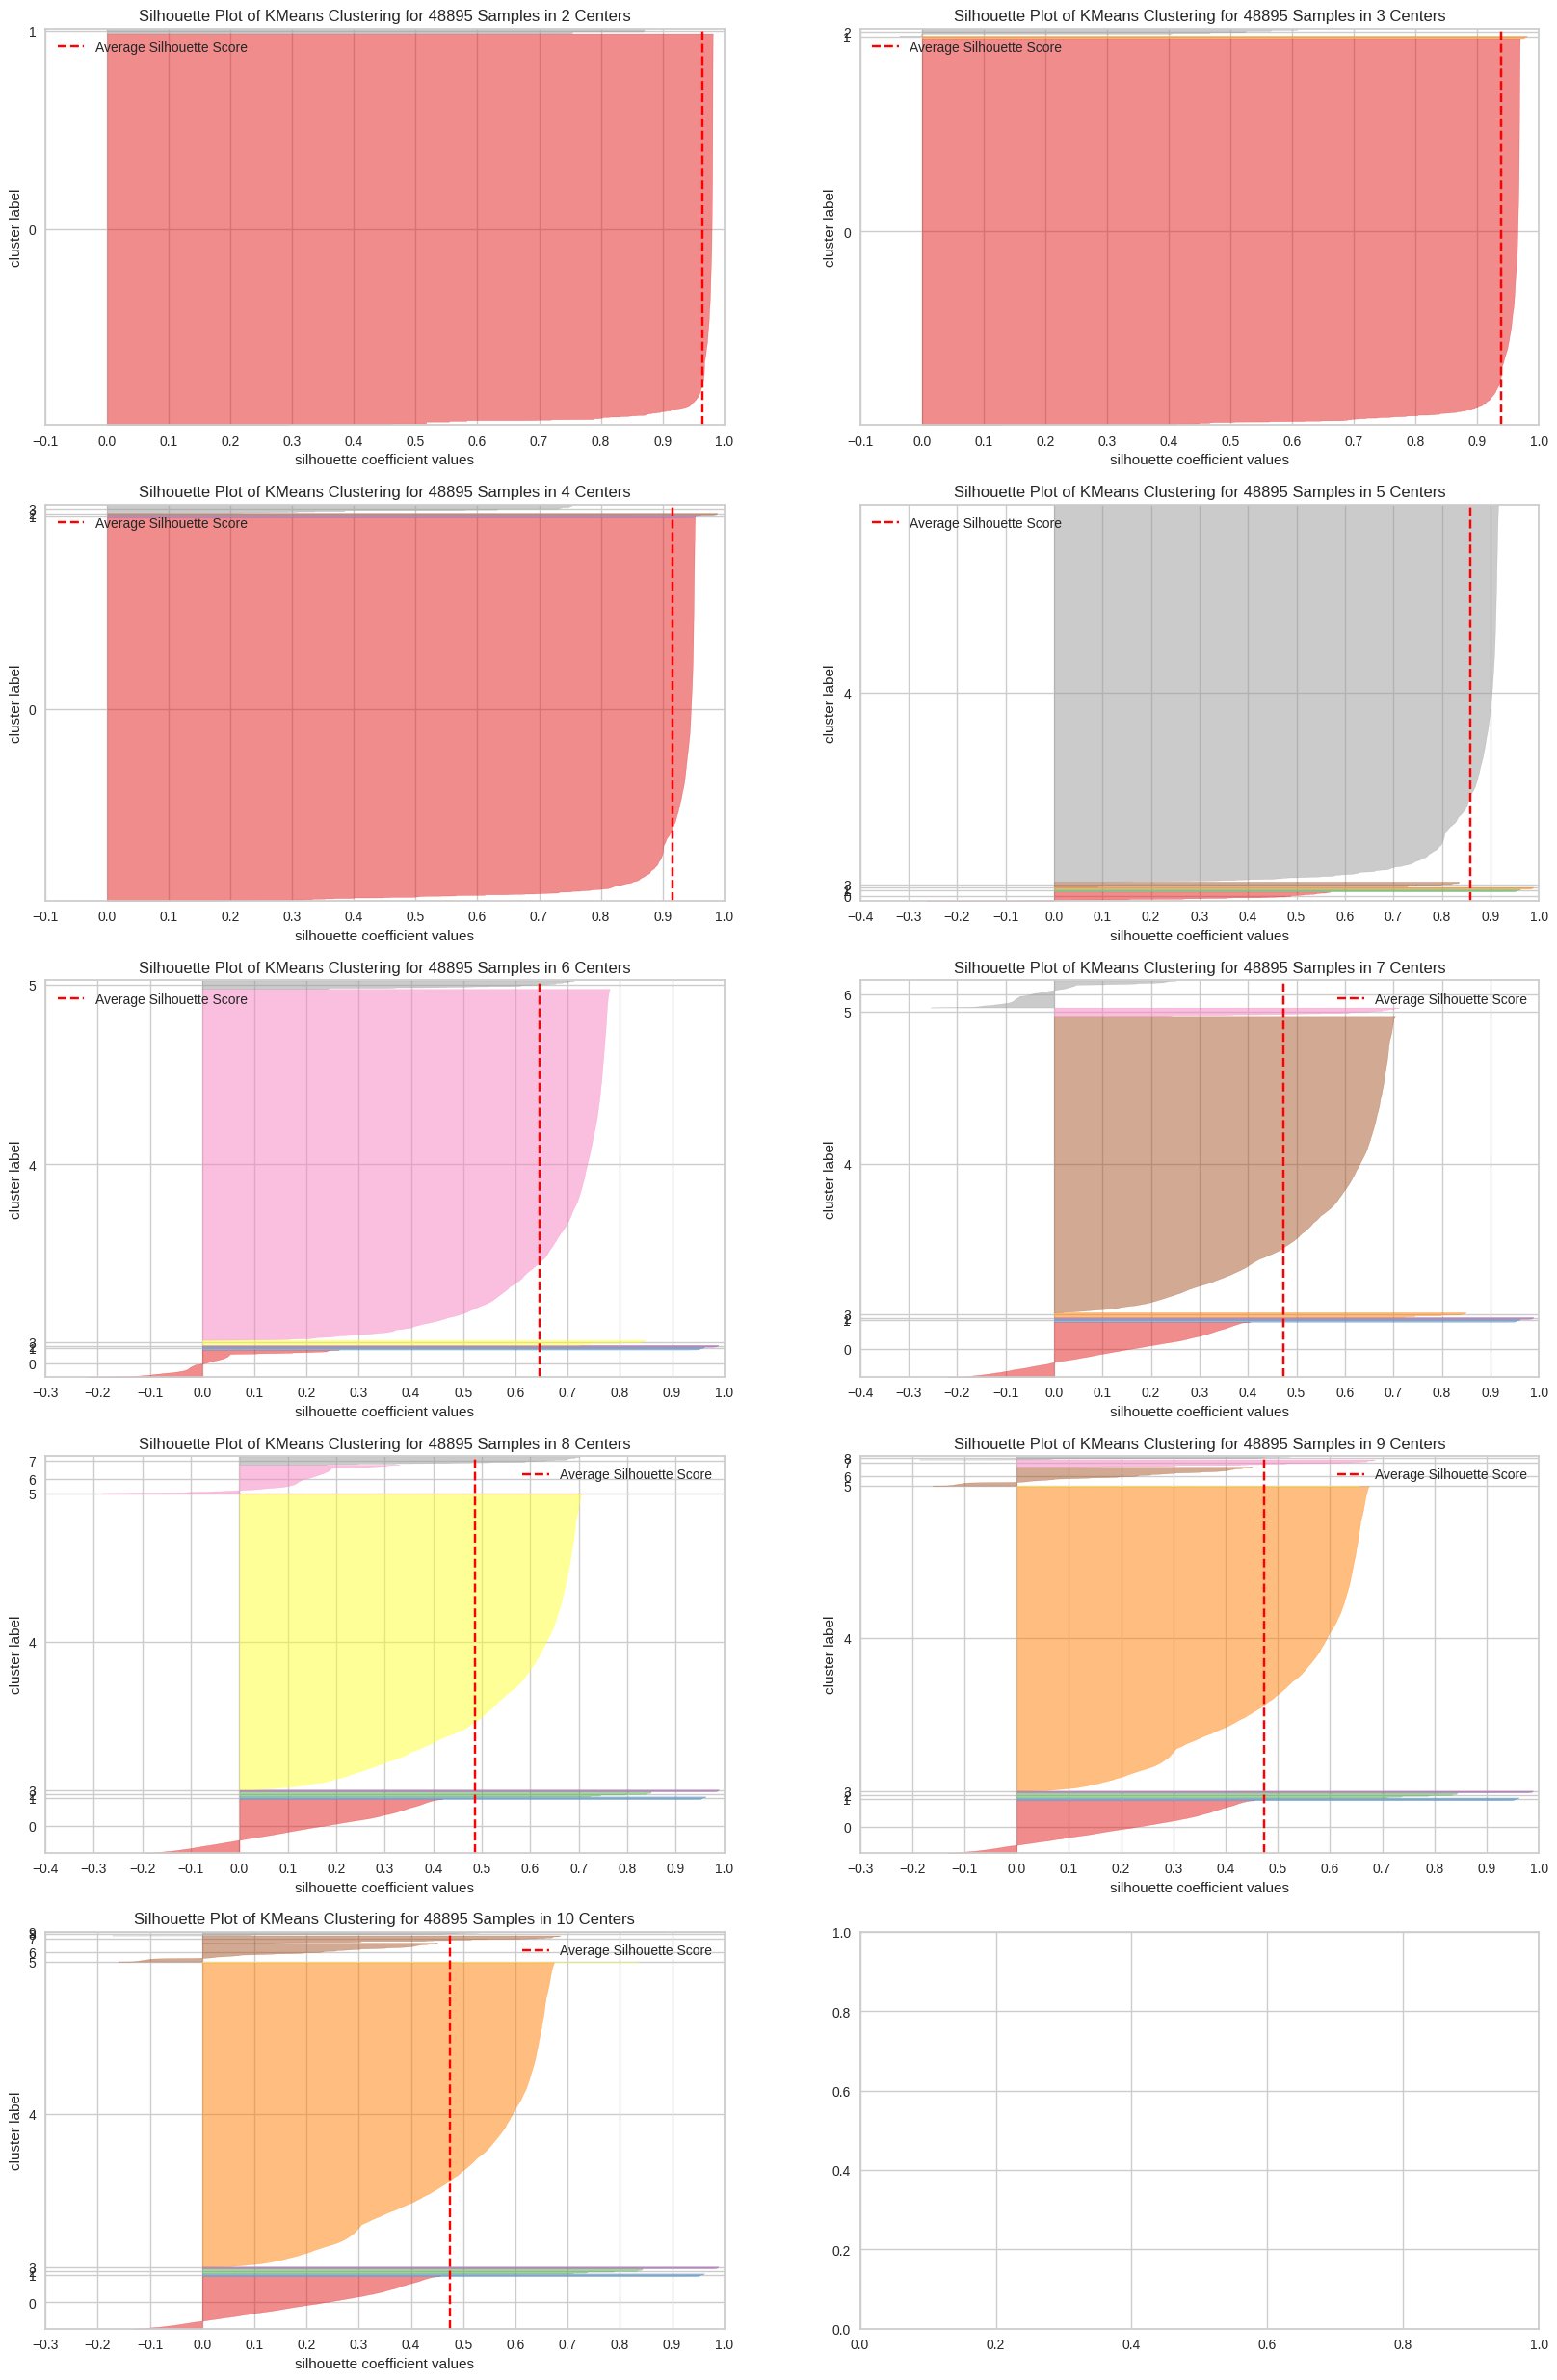

In [ ]:
#eksekusi hasil
inspeksi_kluster(clsdfcom)

In [ ]:
#pemeriksaan nilai siluet
def inspect_silhouette_score(data_scaled, dataset_name):
    silhouette_scores = []
    k_range = range(2, 11)  # Start from 2, as silhouette score is not defined for k=1

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(data_scaled)
        score = silhouette_score(data_scaled, clusters)
        silhouette_scores.append(score)

        # Lihat Optimalisasi Kluster
        if score >= 0.70:
            print(f'Silhouette Score for k={k} is {score:.3f} (>= 0.70) - Klustering Optimal yang Bagus!')
        elif score >= 0.55:
            print(f'Silhouette Score for k={k} is {score:.3f} (>= 0.55) - Klustering Bagus!')
        else:
            print(f'Silhouette Score for k={k} is {score:.3f} (< 0.55) - Penyetelan Nilai k.')

    # Plotting the silhouette scores
    plt.figure(figsize=(9, 6))
    plt.plot(k_range, silhouette_scores, marker='o', color='b')
    plt.title(f'Inspeksi Silhouette Score untuk Kluster - {dataset_name}')
    plt.xlabel('Total Kluster (k)')
    plt.ylabel('Nilai Siluet')
    plt.xticks(k_range)
    plt.axhline(y=0.70, color='b', linestyle='--', label='Rekomendasi : 0.70')
    plt.axhline(y=0.55, color='r', linestyle='--', label='Threshold: 0.55')
    plt.legend()
    plt.grid()
    plt.show()

Silhouette Score for k=2 is 0.965 (>= 0.70) - Klustering Optimal yang Bagus!
Silhouette Score for k=3 is 0.914 (>= 0.70) - Klustering Optimal yang Bagus!
Silhouette Score for k=4 is 0.916 (>= 0.70) - Klustering Optimal yang Bagus!
Silhouette Score for k=5 is 0.858 (>= 0.70) - Klustering Optimal yang Bagus!
Silhouette Score for k=6 is 0.857 (>= 0.70) - Klustering Optimal yang Bagus!
Silhouette Score for k=7 is 0.838 (>= 0.70) - Klustering Optimal yang Bagus!
Silhouette Score for k=8 is 0.797 (>= 0.70) - Klustering Optimal yang Bagus!
Silhouette Score for k=9 is 0.797 (>= 0.70) - Klustering Optimal yang Bagus!
Silhouette Score for k=10 is 0.797 (>= 0.70) - Klustering Optimal yang Bagus!


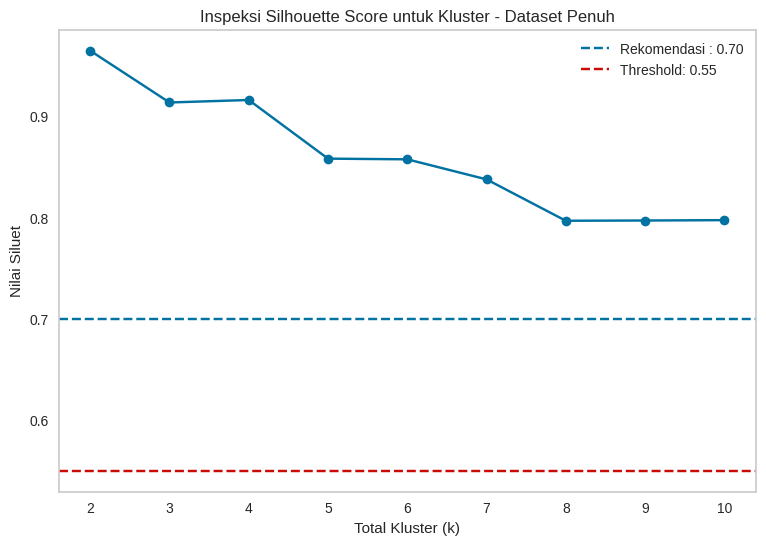

In [ ]:
#fungsi inspeksi untuk unit penuh
inspect_silhouette_score(clsdfcom, 'Dataset Penuh')

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [ ]:
#perpustakaan tambahan untuk seleksi fitur
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
#Tahap awal 'seleksi fitur' di metode sikut dengan 'seleksi fitur
def inspeksi_kluster_dengan_sf(data_scaled, dataset_name, n_features=5, cluster_range=range(2, 11), random_states=[1000], optsil=0.70, silmin=0.55):
    # Feature selection
    selector = SelectKBest(score_func=f_classif, k=n_features)
    data_selected = selector.fit_transform(data_scaled, np.zeros(data_scaled.shape[0]))  # Target variable is dummy

    fig, ax = plt.subplots(5, 2, figsize=(20, 31))

    # Iterate fasa acak
    for random_state in random_states:
        print(f"Dengan fasa acak: {random_state}")

        # Iterasi jangkauan kluster spesifik
        for n_clusters in cluster_range:
            kmeanModel = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
            kmeanModel.fit(data_selected)

            q, mod = divmod(n_clusters, 2)
            sil = SilhouetteVisualizer(kmeanModel, is_fitted=True, ax=ax[q-1][mod])
            sil.fit(data_selected)
            sil.finalize()

            silhouette_score_value = np.round(sil.silhouette_score_, 4)
            print(f"Kluster: {n_clusters}, Nilai siluet: {silhouette_score_value}")

            # Pemeriksaan kondisional
            if silhouette_score_value >= optsil:
                print(f'Nilai siluet untuk k={n_clusters} adalah {silhouette_score_value:.3f} (>= {optsil}) - Klustering Optimal yang Bagus!')
            elif silhouette_score_value >= silmin:
                print(f'Nilai siluet untuk k={n_clusters} adalah {silhouette_score_value:.3f} (>= {silmin}) - Klustering Bagus!')
            else:
                print(f'Nilai siluet untuk k={n_clusters} adalah {silhouette_score_value:.3f} (< {silmin}) - Penyetelan Nilai k.')

  #ke ilustrasi

In [ ]:
# Ilustrasi Hasil Grafik
    inertia = []
    silhouette_scores = []

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data_selected)

        inertia.append(kmeans.inertia_)
        if k > 1:
            score = silhouette_score(data_selected, kmeans.labels_)
            silhouette_scores.append(score)
            print(f'k={k}, Nilai siluet={score:.3f}')  # Check silhouette score

    # Ilustrasi hasil
    plt.figure(figsize=(9, 6))
    plt.plot(cluster_range[:len(inertia)], inertia, marker='o', label='Inersia')

    if len(silhouette_scores) > 1:
        plt.plot(cluster_range[1:len(silhouette_scores)], silhouette_scores[1:], marker='x', color='r', label='Silhouette Score')

    plt.title(f'Hasil Inspeksi untuk - {dataset_name}')
    plt.xlabel('Total kluster (k)')
    plt.ylabel('Inersia / nilai siluet')
    plt.xticks(cluster_range)
    plt.axhline(y=optsil, color='b', linestyle='--', label='Nilai rekomendasi (0.7)')
    plt.axhline(y=silmin, color='r', linestyle='--', label='Nilai minimal (0.55)')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
#Inspeksi nilai siluet dengan 'seleksi fitur'
def plot_fscale_silsc(data_scaled, dataset_name, n_features=5):
    # Feature selection
    selector = SelectKBest(score_func=f_classif, k=n_features)
    data_selected = selector.fit_transform(data_scaled, np.zeros(data_scaled.shape[0]))  # Target minimal

    silhouette_scores = []
    k_range = range(2, 11)  # Nilai Mimimal kluster

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(data_selected)
        score = silhouette_score(data_selected, clusters)
        silhouette_scores.append(score)

        # Pemeriksaan Nilai Siluet
        if score >= 0.70:
            print(f'Nilai siluet untuk k={k} is {score:.3f} (>= 0.70) - Klustering Optimal yang Bagus!')
        elif score >= 0.55:
            print(f'Nilai siluet untuk k={k} is {score:.3f} (>= 0.55) - Klustering Bagus!')
        else:
            print(f'Nilai siluet untuk k={k} is {score:.3f} (< 0.55) - Penyetelan Nilai k.')

    # Plotting the silhouette scores
    plt.figure(figsize=(9, 6))
    plt.plot(k_range, silhouette_scores, marker='o', color='b')
    plt.title(f'Inspeksi Silhouette Score untuk Kluster - {dataset_name}')
    plt.xlabel('Total Kluster (k)')
    plt.ylabel('Nilai Inersia/Siluet')
    plt.xticks(k_range)
    plt.axhline(y=0.70, color='b', linestyle='--', label='Optimized: 0.55')
    plt.axhline(y=0.55, color='r', linestyle='--', label='Threshold: 0.55')
    plt.legend()
    plt.grid()
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)


k=2, Nilai siluet=0.966
Nilai siluet untuk k=2 adalh 0.966 (>= 0.70) - Klustering Bagus!
k=3, Nilai siluet=0.919
Nilai siluet untuk k=3 adalh 0.919 (>= 0.70) - Klustering Bagus!
k=4, Nilai siluet=0.922
Nilai siluet untuk k=4 adalh 0.922 (>= 0.70) - Klustering Bagus!
k=5, Nilai siluet=0.924
Nilai siluet untuk k=5 adalh 0.924 (>= 0.70) - Klustering Bagus!
k=6, Nilai siluet=0.869
Nilai siluet untuk k=6 adalh 0.869 (>= 0.70) - Klustering Bagus!
k=7, Nilai siluet=0.638


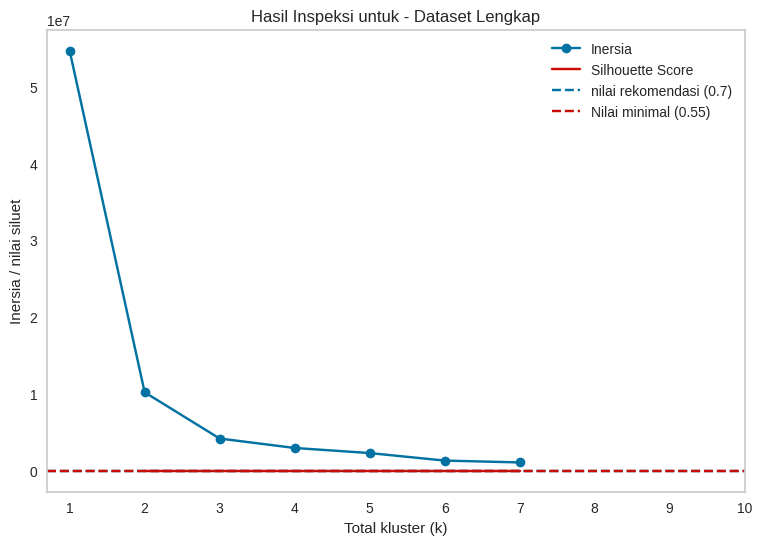

In [ ]:
#Cek hasil
plot_fscale_el(clsdfcom, 'Dataset Lengkap')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)


Nilai siluet untuk k=2 is 0.966 (>= 0.70) - Klustering Optimal yang Bagus!
Nilai siluet untuk k=3 is 0.919 (>= 0.70) - Klustering Optimal yang Bagus!
Nilai siluet untuk k=4 is 0.922 (>= 0.70) - Klustering Optimal yang Bagus!
Nilai siluet untuk k=5 is 0.924 (>= 0.70) - Klustering Optimal yang Bagus!
Nilai siluet untuk k=6 is 0.869 (>= 0.70) - Klustering Optimal yang Bagus!
Nilai siluet untuk k=7 is 0.638 (>= 0.55) - Klustering Bagus!
Nilai siluet untuk k=8 is 0.661 (>= 0.55) - Klustering Bagus!
Nilai siluet untuk k=9 is 0.519 (< 0.55) - Penyetelan Nilai k.
Nilai siluet untuk k=10 is 0.550 (< 0.55) - Penyetelan Nilai k.


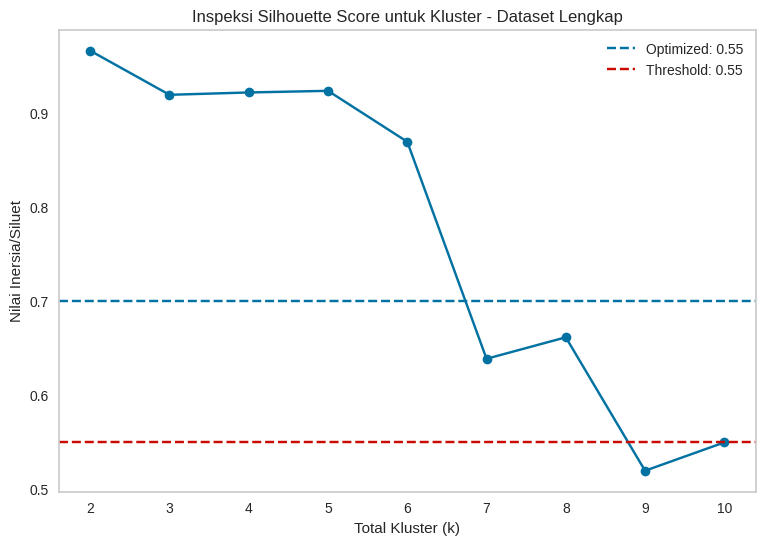

In [ ]:
#cek hasil setelah penyetelan skala
plot_fscale_silsc(clsdfcom, 'Dataset Lengkap')

### Perbandingan hasil 'seleksi fitur' dengan hasil normal

In [ ]:
#Perbandingan


## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [ ]:
#perpustakaan tambahan
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
#tahap 'standard scaler'
stdscaler = StandardScaler()
clsstd = stdscaler.fit_transform(clsdfcom)
clsstd = pd.DataFrame(clsstd, columns=clsdfcom.columns)
clsstd.head()

In [ ]:
#penyetalan model PCA
pca = PCA(n_components=0.90)

# Fit and transform the data
clspca = pca.fit_transform(clsstd)

In [ ]:
#Tahap penjelasan informasi
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
#ke hasil

In [ ]:
#cetak hasil
print("Penjelasan komponen PCA dari berbagai variasi:", np.round(explained_variance,3))
print("Komponen PCA yang dijelaskan secara kumulatif:", np.round(cumulative_variance,3))

Penjelasan komponen PCA dari berbagai variasi: [0.26  0.239 0.16  0.152 0.111]
Komponen PCA yang dijelaskan secara kumulatif: [0.26  0.499 0.658 0.81  0.922]


Explained Variance Ratio: [0.25987045 0.23876072 0.15968634 0.1520952  0.11141341]


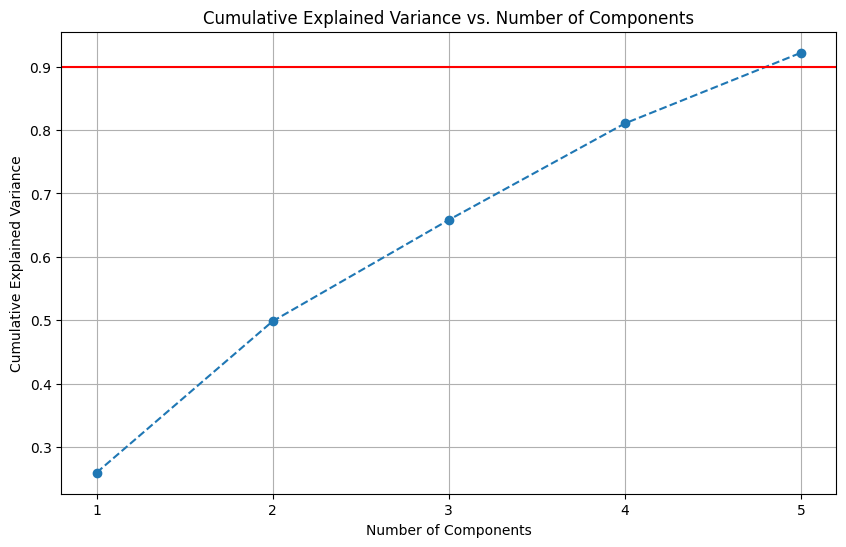

In [ ]:
#inspeksi hasil variatif kumulasi
print("Explained Variance Ratio:", explained_variance)

# Step 4: Visualisasi kumulatif variasi
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='-')  # Batas tershold 90%
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Total Komponen')
plt.ylabel('Varian Kumulatif yang terrinci')
plt.grid()
plt.xticks(range(1, len(cumulative_variance) + 1))  # Referensi
plt.show()

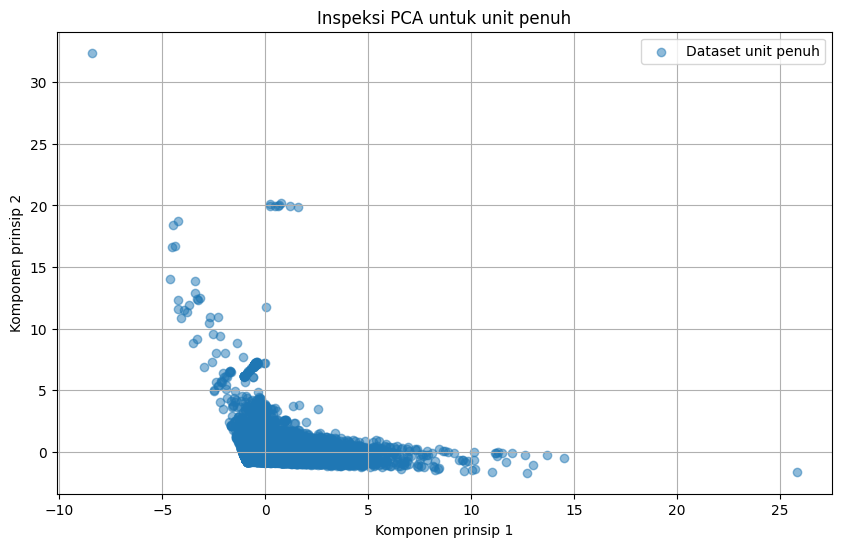

In [ ]:
#Tahap visualisasi hasil PCA (variasi referensi 1)
plt.figure(figsize=(10, 6))

# Plot for fdf_pca
plt.scatter(fdf_pca[:, 0], _pca[:, 1], alpha=0.5, label='Dataset unit penuh')
plt.title('Inspeksi PCA untuk unit penuh')
plt.xlabel('Komponen prinsip 1')
plt.ylabel('Komponen prinsip 2')
plt.legend()
plt.grid()
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [ ]:
#Inspeksi Analisis data total


NameError: name 'k_means1' is not defined

In [ ]:
#inspeksi di hasil kamar utuh


In [ ]:
#Inspeksi di hasil berbagi


In [ ]:
#Pergantian Nama


Tulis hasil interpretasinya di sini.
1. Cluster 1:
2. Cluster 2:
3. Cluster 3:

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.